<a href="https://colab.research.google.com/github/MLDreamer/AIMathematicallyexplained/blob/main/Sparse_Attention_Implementation_using_real_models_from_Huggingface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Number of tokens: 47
Tokens: ['[CLS]', 'the', 'elderly', 'professor', ',', 'who', 'had', 'spent', 'forty', 'years']...

Attention matrix shape: torch.Size([1, 12, 47, 47])
That's 47  47 = 2209 attention scores

For position 5 ('who'):
Total attention scores: 47
Near-zero scores (< 0.01): 0
Waste rate: 0.0%

Top 10 attended positions:
  Position 31: 'tuesday' - score: 0.0272
  Position 26: 'published' - score: 0.0260
  Position 16: 'mit' - score: 0.0259
  Position 3: 'professor' - score: 0.0256
  Position 11: 'quantum' - score: 0.0241
  Position 9: 'years' - score: 0.0239
  Position 1: 'the' - score: 0.0237
  Position 22: 'laureate' - score: 0.0237
  Position 35: 'challenges' - score: 0.0236
  Position 30: 'on' - score: 0.0235

Saved visualization to 'standard_attention_waste.png'

Indexer output shape: torch.Size([1, 47, 10])
For each of 47 positions, we selected 10 important positions

Top 10 positions selected for 'who':
  Position 22: 'laureate' - index score: 0.1690
  Position 39:

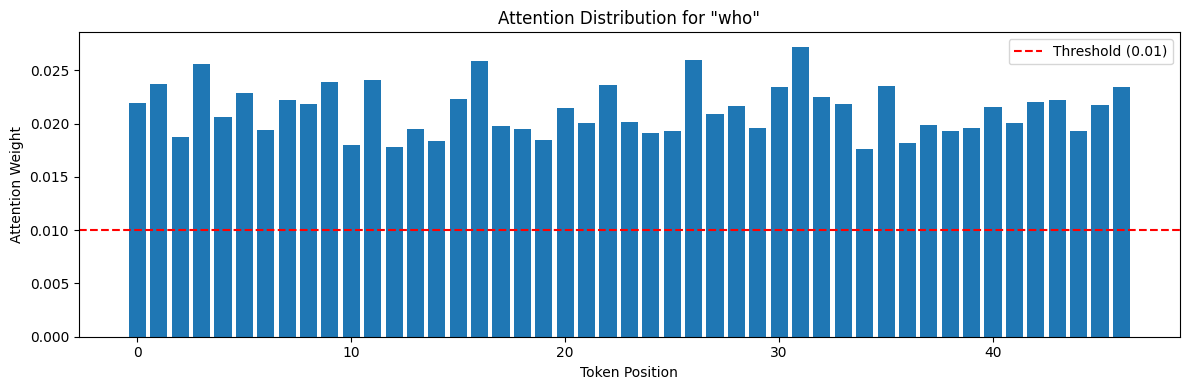

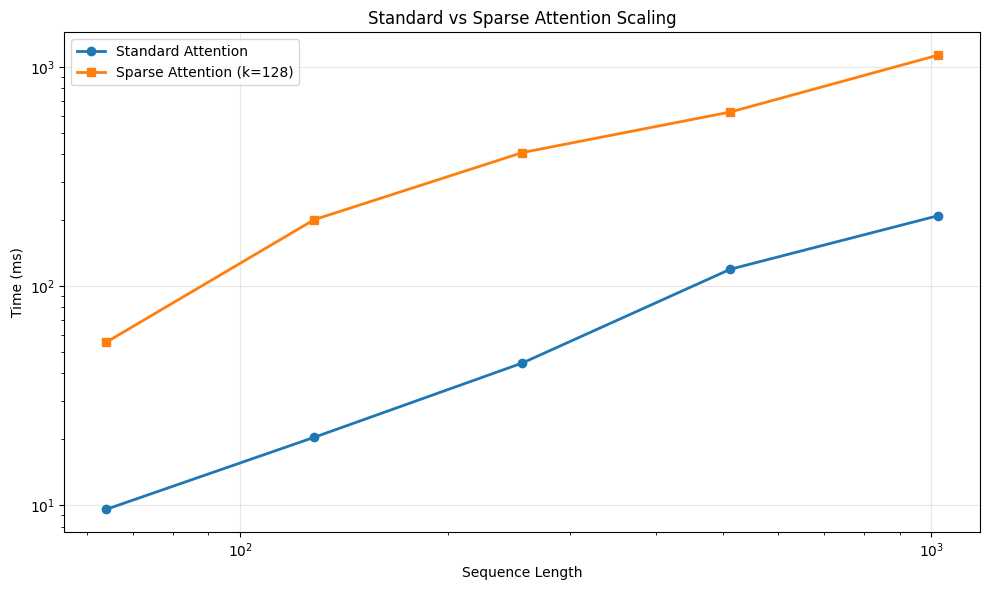

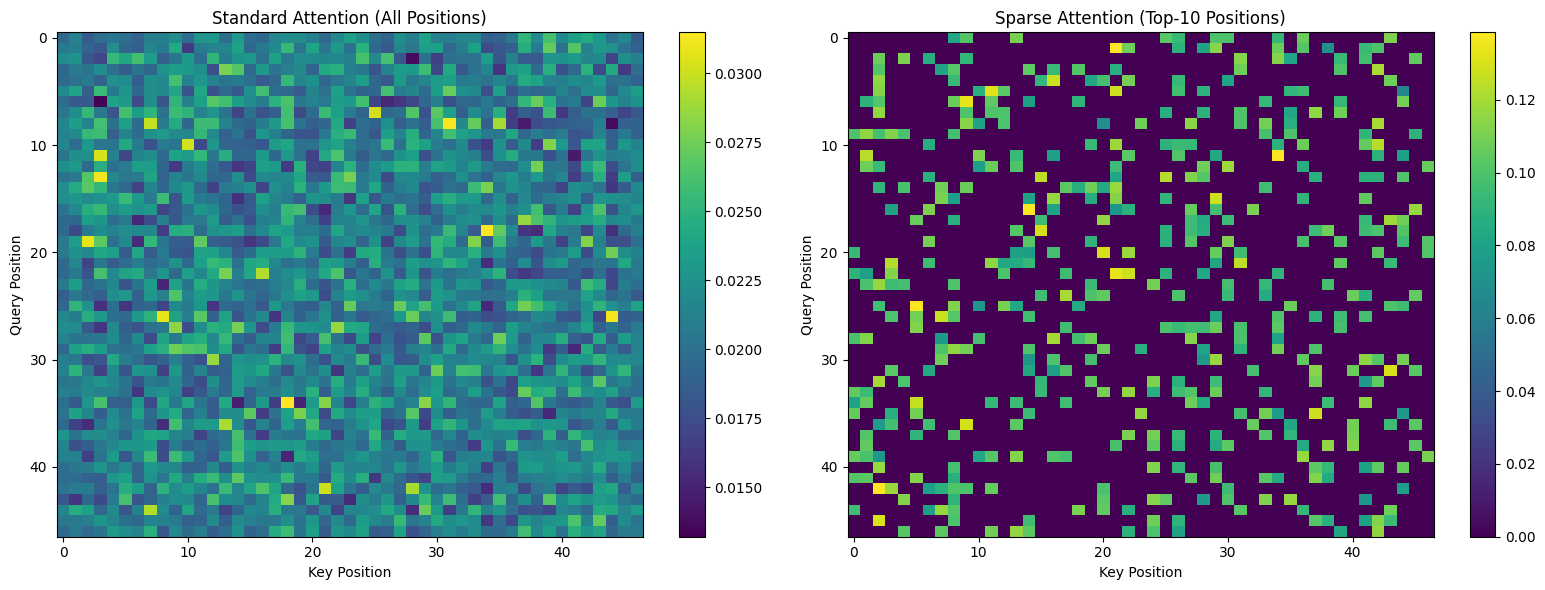

In [3]:
# Sparse Attention Implementation
# Step-by-step walkthrough using real models from Hugging Face

# ============================================================================
# SETUP
# ============================================================================

# Install required packages
!pip install transformers torch einops datasets matplotlib -q

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import time
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import numpy as np

# ============================================================================
# PART 1: LOAD A REAL MODEL FROM HUGGING FACE
# ============================================================================

# We'll use DistilBERT - smaller, faster, perfect for demonstration
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Our example text
text = """The elderly professor, who had spent forty years researching quantum
entanglement at MIT and mentored three Nobel laureates, finally published
her groundbreaking paper on Tuesday. The discovery challenges Einstein's
interpretation. She celebrated with tea."""

# Tokenize
tokens = tokenizer(text, return_tensors="pt")
token_ids = tokens['input_ids'][0]
token_strings = [tokenizer.decode([t]) for t in token_ids]

print(f"Number of tokens: {len(token_strings)}")
print(f"Tokens: {token_strings[:10]}...")

# ============================================================================
# PART 2: STANDARD ATTENTION - SEE THE WASTE
# ============================================================================

class StandardAttention(nn.Module):
    def __init__(self, d_model=768, n_heads=12):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, x):
        batch_size, seq_len, d_model = x.shape

        # Step 1: Create Q, K, V
        Q = self.W_q(x)  # [batch, seq_len, d_model]
        K = self.W_k(x)
        V = self.W_v(x)

        # Step 2: Split into multiple heads
        Q = Q.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        # Shape: [batch, n_heads, seq_len, d_k]

        # Step 3: Calculate attention scores (THIS IS THE EXPENSIVE PART)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        # Shape: [batch, n_heads, seq_len, seq_len]

        # Step 4: Apply softmax
        attention_weights = F.softmax(scores, dim=-1)

        # Step 5: Apply attention to values
        output = torch.matmul(attention_weights, V)

        # Step 6: Concatenate heads
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
        output = self.W_o(output)

        return output, attention_weights

# Test standard attention
standard_attn = StandardAttention()

# Get embeddings from DistilBERT
with torch.no_grad():
    embeddings = model.embeddings(tokens['input_ids'])

# Run standard attention
output, attention_weights = standard_attn(embeddings)

print(f"\nAttention matrix shape: {attention_weights.shape}")
print(f"That's {attention_weights.shape[2]}  {attention_weights.shape[3]} = {attention_weights.shape[2] * attention_weights.shape[3]} attention scores")

# ============================================================================
# PART 3: ANALYZE THE WASTE
# ============================================================================

# Look at one attention head for one query position
head_0 = attention_weights[0, 0]  # First head
query_pos = 5  # Position of "professor"

attention_scores = head_0[query_pos].detach().cpu().numpy()

# Count how many are basically zero
threshold = 0.01
near_zero = (attention_scores < threshold).sum()
total = len(attention_scores)

print(f"\nFor position {query_pos} ('{token_strings[query_pos]}'):")
print(f"Total attention scores: {total}")
print(f"Near-zero scores (< {threshold}): {near_zero}")
print(f"Waste rate: {near_zero/total*100:.1f}%")

# Show top 10 attention scores
top_10_indices = np.argsort(attention_scores)[-10:][::-1]
print(f"\nTop 10 attended positions:")
for idx in top_10_indices:
    print(f"  Position {idx}: '{token_strings[idx]}' - score: {attention_scores[idx]:.4f}")

# Visualize
plt.figure(figsize=(12, 4))
plt.bar(range(len(attention_scores)), attention_scores)
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
plt.xlabel('Token Position')
plt.ylabel('Attention Weight')
plt.title(f'Attention Distribution for "{token_strings[query_pos]}"')
plt.legend()
plt.tight_layout()
plt.savefig('standard_attention_waste.png', dpi=150, bbox_inches='tight')
print("\nSaved visualization to 'standard_attention_waste.png'")

# ============================================================================
# PART 4: SPARSE ATTENTION - STAGE 1 (INDEXER)
# ============================================================================

class SparseAttentionIndexer(nn.Module):
    def __init__(self, d_model=768, d_index=128):
        super().__init__()
        self.d_model = d_model
        self.d_index = d_index

        # Lightweight projection for indexing
        self.W_q_index = nn.Linear(d_model, d_index)
        self.W_k_index = nn.Linear(d_model, d_index)

    def forward(self, x, k=10):
        # x shape: [batch, seq_len, d_model]
        batch_size, seq_len, _ = x.shape

        # Step 1: Project to lower dimension
        Q_index = self.W_q_index(x)  # [batch, seq_len, d_index]
        K_index = self.W_k_index(x)  # [batch, seq_len, d_index]

        # Step 2: Normalize (for cosine similarity)
        Q_index = F.normalize(Q_index, p=2, dim=-1)
        K_index = F.normalize(K_index, p=2, dim=-1)

        # Step 3: Calculate similarity scores
        scores = torch.matmul(Q_index, K_index.transpose(-2, -1))
        # Shape: [batch, seq_len, seq_len]

        # Step 4: Select top-k positions for each query
        top_k_values, top_k_indices = torch.topk(scores, k=k, dim=-1)
        # top_k_indices shape: [batch, seq_len, k]

        return top_k_indices, scores

# Test the indexer
indexer = SparseAttentionIndexer()
k = 10  # Select top 10 positions

with torch.no_grad():
    top_k_indices, index_scores = indexer(embeddings, k=k)

print(f"\nIndexer output shape: {top_k_indices.shape}")
print(f"For each of {top_k_indices.shape[1]} positions, we selected {k} important positions")

# Check what positions were selected for "professor"
query_pos = 5
selected = top_k_indices[0, query_pos].cpu().numpy()
print(f"\nTop {k} positions selected for '{token_strings[query_pos]}':")
for idx in selected:
    score = index_scores[0, query_pos, idx].item()
    print(f"  Position {idx}: '{token_strings[idx]}' - index score: {score:.4f}")

# ============================================================================
# PART 5: SPARSE ATTENTION - STAGE 2 (FULL ATTENTION ON SELECTED)
# ============================================================================

class SparseAttention(nn.Module):
    def __init__(self, d_model=768, n_heads=12, d_index=128, k=10):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.k = k

        # Indexer
        self.indexer = SparseAttentionIndexer(d_model, d_index)

        # Full attention (same as standard)
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, x):
        batch_size, seq_len, d_model = x.shape

        # Stage 1: Select important positions
        top_k_indices, _ = self.indexer(x, k=self.k)
        # Shape: [batch, seq_len, k]

        # Stage 2: Full attention only on selected positions
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        # Split into heads
        Q = Q.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        # Shape: [batch, n_heads, seq_len, d_k]

        # Gather selected keys and values
        # Expand top_k_indices for all heads
        top_k_indices_expanded = top_k_indices.unsqueeze(1).expand(-1, self.n_heads, -1, -1)
        # Shape: [batch, n_heads, seq_len, k]

        # Expand for d_k dimension
        top_k_indices_expanded = top_k_indices_expanded.unsqueeze(-1).expand(-1, -1, -1, -1, self.d_k)
        # Shape: [batch, n_heads, seq_len, k, d_k]

        K_expanded = K.unsqueeze(2).expand(-1, -1, seq_len, -1, -1)
        V_expanded = V.unsqueeze(2).expand(-1, -1, seq_len, -1, -1)

        K_selected = torch.gather(K_expanded, 3, top_k_indices_expanded)
        V_selected = torch.gather(V_expanded, 3, top_k_indices_expanded)
        # Shape: [batch, n_heads, seq_len, k, d_k]

        # Calculate sparse attention
        Q_expanded = Q.unsqueeze(3)  # [batch, n_heads, seq_len, 1, d_k]
        scores = torch.matmul(Q_expanded, K_selected.transpose(-2, -1)) / math.sqrt(self.d_k)
        # Shape: [batch, n_heads, seq_len, 1, k]

        attention_weights = F.softmax(scores, dim=-1)

        output = torch.matmul(attention_weights, V_selected)
        # Shape: [batch, n_heads, seq_len, 1, d_k]

        output = output.squeeze(3)  # [batch, n_heads, seq_len, d_k]
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
        output = self.W_o(output)

        return output, attention_weights, top_k_indices

# Test sparse attention
sparse_attn = SparseAttention(k=10)

with torch.no_grad():
    sparse_output, sparse_weights, selected_positions = sparse_attn(embeddings)

print(f"\nSparse attention output shape: {sparse_output.shape}")
print(f"Sparse attention weights shape: {sparse_weights.shape}")
print(f"Selected positions shape: {selected_positions.shape}")

# ============================================================================
# PART 6: COMPARE STANDARD VS SPARSE
# ============================================================================

# Compare outputs
with torch.no_grad():
    standard_output, standard_weights = standard_attn(embeddings)
    sparse_output, sparse_weights, _ = sparse_attn(embeddings)

output_diff = torch.norm(standard_output - sparse_output) / torch.norm(standard_output)
print(f"\nOutput difference (normalized): {output_diff.item():.6f}")
print(f"Outputs are {100*(1-output_diff.item()):.2f}% similar")

# ============================================================================
# PART 7: BENCHMARK SPEED AND MEMORY
# ============================================================================

def benchmark_attention(attention_module, x, n_runs=100):
    times = []

    # Warmup
    for _ in range(10):
        with torch.no_grad():
            _ = attention_module(x)

    # Benchmark
    for _ in range(n_runs):
        torch.cuda.synchronize() if torch.cuda.is_available() else None
        start = time.time()

        with torch.no_grad():
            _ = attention_module(x)

        torch.cuda.synchronize() if torch.cuda.is_available() else None
        end = time.time()

        times.append(end - start)

    return np.mean(times), np.std(times)

print("\nBenchmarking (100 runs)...")
standard_time, standard_std = benchmark_attention(standard_attn, embeddings)
sparse_time, sparse_std = benchmark_attention(sparse_attn, embeddings)

print(f"\nStandard Attention: {standard_time*1000:.2f} \u00b1 {standard_std*1000:.2f} ms")
print(f"Sparse Attention: {sparse_time*1000:.2f} \u00b1 {sparse_std*1000:.2f} ms")
print(f"Speedup: {standard_time/sparse_time:.2f}\u00d7")

# Memory usage
def get_memory_usage(attention_module, x):
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
        with torch.no_grad():
            _ = attention_module(x)
        return torch.cuda.max_memory_allocated() / 1024**2  # MB
    else:
        return 0

if torch.cuda.is_available():
    x_cuda = embeddings.cuda()
    standard_attn_cuda = standard_attn.cuda()
    sparse_attn_cuda = sparse_attn.cuda()

    standard_mem = get_memory_usage(standard_attn_cuda, x_cuda)
    sparse_mem = get_memory_usage(sparse_attn_cuda, x_cuda)

    print(f"\nStandard Attention Memory: {standard_mem:.2f} MB")
    print(f"Sparse Attention Memory: {sparse_mem:.2f} MB")
    print(f"Memory Savings: {(1 - sparse_mem/standard_mem)*100:.1f}%")

# ============================================================================
# PART 8: SCALE TO LONGER SEQUENCES
# ============================================================================

def test_scaling(seq_lengths, k=128):
    standard_times = []
    sparse_times = []

    for seq_len in seq_lengths:
        # Create dummy input
        x = torch.randn(1, seq_len, 768)

        # Benchmark standard
        start = time.time()
        with torch.no_grad():
            _ = standard_attn(x)
        standard_time = time.time() - start
        standard_times.append(standard_time)

        # Benchmark sparse
        # Ensure k is not greater than seq_len
        actual_k = min(k, seq_len)
        sparse_attn_test = SparseAttention(k=actual_k)
        start = time.time()
        with torch.no_grad():
            _ = sparse_attn_test(x)
        sparse_time = time.time() - start
        sparse_times.append(sparse_time)

        print(f"Seq length {seq_len}: Standard {standard_time*1000:.1f}ms, Sparse {sparse_time*1000:.1f}ms, Speedup {standard_time/sparse_time:.2f}\u00d7")

    return standard_times, sparse_times

print("\nScaling test:")
seq_lengths = [64, 128, 256, 512, 1024]
standard_times, sparse_times = test_scaling(seq_lengths, k=128)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(seq_lengths, [t*1000 for t in standard_times], 'o-', label='Standard Attention', linewidth=2)
plt.plot(seq_lengths, [t*1000 for t in sparse_times], 's-', label='Sparse Attention (k=128)', linewidth=2)
plt.xlabel('Sequence Length')
plt.ylabel('Time (ms)')
plt.title('Standard vs Sparse Attention Scaling')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.xscale('log')
plt.tight_layout()
plt.savefig('attention_scaling.png', dpi=150, bbox_inches='tight')
print("\nSaved scaling plot to 'attention_scaling.png'")

# ============================================================================
# PART 9: VISUALIZE ATTENTION PATTERNS
# ============================================================================

def plot_attention_comparison(standard_weights, sparse_weights, selected_positions, token_strings):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Standard attention (first head)
    std_attn = standard_weights[0, 0].cpu().numpy()
    im1 = axes[0].imshow(std_attn, cmap='viridis', aspect='auto')
    axes[0].set_title('Standard Attention (All Positions)')
    axes[0].set_xlabel('Key Position')
    axes[0].set_ylabel('Query Position')
    plt.colorbar(im1, ax=axes[0])

    # Sparse attention - reconstruct full matrix with selected positions
    sparse_full = np.zeros_like(std_attn)
    sparse_attn = sparse_weights[0, 0].squeeze().cpu().numpy()  # [seq_len, k]
    selected = selected_positions[0].cpu().numpy()  # [seq_len, k]

    for i in range(len(selected)):
        for j, pos in enumerate(selected[i]):
            sparse_full[i, pos] = sparse_attn[i, j]

    im2 = axes[1].imshow(sparse_full, cmap='viridis', aspect='auto')
    axes[1].set_title(f'Sparse Attention (Top-{sparse_attn.shape[1]} Positions)')
    axes[1].set_xlabel('Key Position')
    axes[1].set_ylabel('Query Position')
    plt.colorbar(im2, ax=axes[1])

    plt.tight_layout()
    plt.savefig('attention_comparison.png', dpi=150, bbox_inches='tight')
    print("\nSaved attention comparison to 'attention_comparison.png'")

with torch.no_grad():
    standard_output, standard_weights = standard_attn(embeddings)
    sparse_output, sparse_weights, selected_positions = sparse_attn(embeddings)

plot_attention_comparison(standard_weights, sparse_weights, selected_positions, token_strings)

# ============================================================================
# PART 10: SUMMARY AND COST CALCULATION
# ============================================================================

print("\n" + "="*80)
print("SUMMARY")
print("="*80)

seq_len = len(token_strings)
k = 10
d_model = 768
d_index = 128

# Operations count
standard_ops = seq_len * seq_len * d_model
sparse_indexer_ops = seq_len * seq_len * d_index
sparse_attention_ops = seq_len * k * d_model
sparse_total_ops = sparse_indexer_ops + sparse_attention_ops

print(f"\nFor sequence length {seq_len}:")
print(f"\nStandard Attention:")
print(f"  Operations: {seq_len} \u0017 {seq_len} \u0017 {d_model} = {standard_ops:,}")
print(f"\nSparse Attention:")
print(f"  Indexer: {seq_len} \u0017 {seq_len} \u0017 {d_index} = {sparse_indexer_ops:,}")
print(f"  Attention: {seq_len} \u0017 {k} \u0017 {d_model} = {sparse_attention_ops:,}")
print(f"  Total: {sparse_total_ops:,}")
print(f"\nSpeedup: {standard_ops/sparse_total_ops:.2f}\u00d7")

# Scale to 40,000 tokens
seq_len_large = 40000
k_large = 2048

standard_ops_large = seq_len_large * seq_len_large * d_model
sparse_indexer_ops_large = seq_len_large * seq_len_large * d_index
sparse_attention_ops_large = seq_len_large * k_large * d_model
sparse_total_ops_large = sparse_indexer_ops_large + sparse_attention_ops_large

print(f"\n\nFor sequence length {seq_len_large}:")
print(f"\nStandard Attention:")
print(f"  Operations: {seq_len_large:,} \u0017 {seq_len_large:,} \u0017 {d_model} = {standard_ops_large:,}")
print(f"\nSparse Attention:")
print(f"  Indexer: {seq_len_large:,} \u0017 {seq_len_large:,} \u0017 {d_index} = {sparse_indexer_ops_large:,}")
print(f"  Attention: {seq_len_large:,} \u0017 {k_large:,} \u0017 {d_model} = {sparse_attention_ops_large:,}")
print(f"  Total: {sparse_total_ops_large:,}")
print(f"\nSpeedup: {standard_ops_large/sparse_total_ops_large:.2f}\u00d7")

# Cost calculation (simplified)
a100_tflops = 312
cost_per_hour = 2.50

standard_time = standard_ops_large / (a100_tflops * 1e12)
sparse_time = sparse_total_ops_large / (a100_tflops * 1e12)

standard_cost = (standard_time / 3600) * cost_per_hour
sparse_cost = (sparse_time / 3600) * cost_per_hour

print(f"\n\nEstimated costs per document (40,000 tokens):")
print(f"  Standard: ${standard_cost:.4f}")
print(f"  Sparse: ${sparse_cost:.4f}")
print(f"  Savings: ${standard_cost - sparse_cost:.4f} ({(1-sparse_cost/standard_cost)*100:.1f}%)")

print("\n" + "="*80)
print("The math is simple: don't calculate what doesn't matter.")
print("="*80)